In [1390]:
import numpy as np 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import control.matlab as control_
import control
import math 
from sympy import symbols, solve

def pos(lst):
    return [x for x in lst if x > 0] or None

pi=math.pi
X= symbols('x')
PM=math.radians(75)
eq=((X-(1/X))/2)-(np.tan(PM))
x=float(pos(solve(eq,X))[0])
#Assigning some constants 
Fref=160e6
Fc=2.76464069e+06
R_ratio=4
P_divider=6
N=21
Fo=560e6
KVCO=90e6
Icp=1e-3
Fp=x*Fc
Fz=Fc/x
k=(KVCO*Icp)/(2*pi*N)
R1=(2*(pi)*Fc)/(k*(1-(1/(x**2))))
wz=2*pi*Fz                       
C1=1/(R1*wz)
C2=C1/((x**2)-1)
Ceq=C1*C2/(C1+C2)

In [1393]:
#VCO phase noise 
w=np.linspace(2*pi*12e3,2*pi*20e6,100000)
T_osc=control.tf([1,315.234e3],[1,0])
T_osc=T_osc*103.9
s=control.tf([1],[1,0,0])
T_osc=T_osc*s
T_osc

TransferFunction(array([1.03900000e+02, 3.27528126e+07]), array([1, 0, 0, 0]))

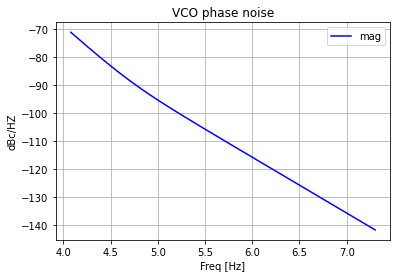

In [1394]:
#VCO phase noise 
(mag, phase_rad, w) = control.bode(T_osc, w,dB=True,Hz=True,plot=False)
for i in range(np.shape(w)[0]):
    if 10*np.log10(mag[i]) <= -145 :
        mag[i:]=mag[i]
        break
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('VCO phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [1426]:
#Reference phase noise 
T_ref=control.tf([1,16000*pi],[1,0])
T_ref=T_ref*3.81115e-3
s=control.tf([1],[1,0,0])
T_ref=T_ref*s
T_ref

TransferFunction(array([3.81115000e-03, 1.91569293e+02]), array([1, 0, 0, 0]))

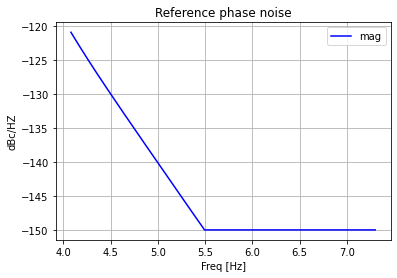

In [1427]:
#Reference phase noise 
(mag_ref, phase_rad_ref, w) = control.bode(T_ref, w,dB=True,Hz=True,plot=False)
for i in range(np.shape(w)[0]):
    if 10*np.log10(mag_ref[i]) <= -150 :
        mag_ref[i:]=mag_ref[i]
        break
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_ref), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('Reference phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [1428]:
# transfer noise of loop filter is RC circuit noise 
T_loopfilter=4*4.11e-21*R1

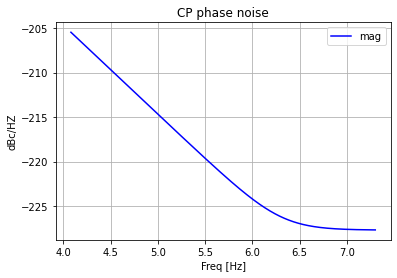

In [1429]:
#CP 
T_CP_noise=control.tf([1,2*2e6*pi],[1,0])
T_CP_noise=T_CP_noise*(5.10613e-24*(Icp))/(300e-6)
(mag_CP_noise, phase_rad_CP_noise, w) = control.bode(T_CP_noise, w,dB=True,Hz=True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_CP_noise), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('CP phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [1430]:
T_CP_noise

TransferFunction(array([5.1061300e-27, 6.4165522e-20]), array([0.0003, 0.    ]))

TransferFunction(array([2.98260458e-04, 6.82092613e+02]), array([1.30133064e-19, 1.71702697e-11, 0.00000000e+00, 0.00000000e+00]))

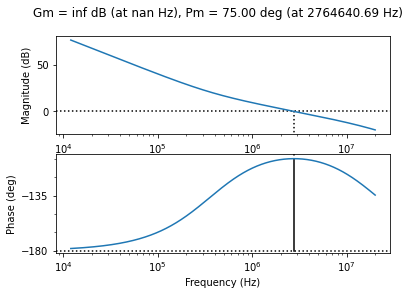

In [1431]:
# open gain for Feedback loop 
Ts=control.tf([R1*C1*k,k],[R1*Ceq,1,0,0])
Ts=Ts/((C1+C2))
(mag_Feed, phase_rad_Feed, w) = control.bode_plot(Ts, w,dB=True, deg= True ,Hz=True, margins=True)
Ts

In [1432]:
# # Feedback of the loop in the middle 
# #Closed loop 
# Bs_=(Ts)/(1+(Ts))
# (mag_FB, phase_rad_FB, w) = control.bode_plot(Bs, w,dB=True, deg= True )

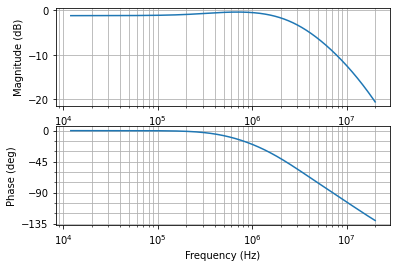

In [1433]:
# the overall closed loop
Bs=(Ts*N)/(1+(Ts))
Bs=Bs/(R_ratio*P_divider)
(mag_FB, phase_rad_FB, w) = control.bode_plot(Bs, w,dB=True, Hz=True,deg= True )


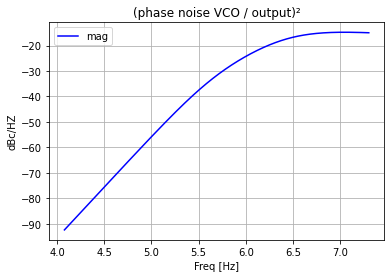

In [1434]:
#Transfer function of different blocks 
#Transfer function of VCO phase output to phase of VCO
T_out_VCO=1/((1+(Ts))*P_divider)
(mag_out_VCO, phase_out_VCO, w) = control.bode_plot(T_out_VCO, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_VCO)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(phase noise VCO / output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

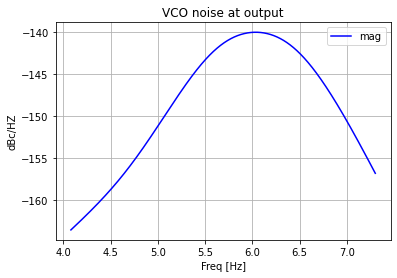

In [1435]:
VCO_noise_output=mag*((mag_out_VCO)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('VCO noise at output')
plt.grid() 
plt.legend(labels=('mag',))

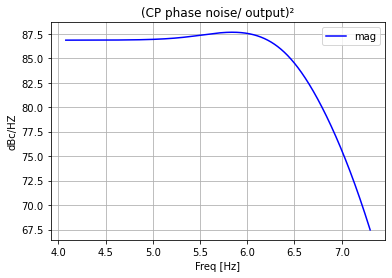

In [1436]:
#Transfer function of different blocks 
#Transfer function of CP phase output to phase of CP
T_out_CP=Ts*((2*pi)/Icp)*N
T_out_CP=T_out_CP/(1+Ts)
T_out_CP=T_out_CP/P_divider
(mag_out_CP, phase_out_CP, w) = control.bode_plot(T_out_CP, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_CP)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(CP phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

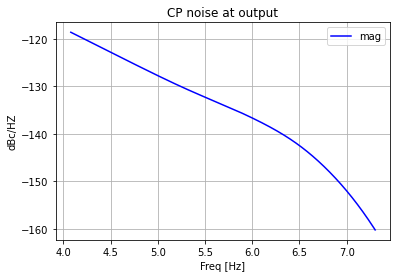

In [1437]:
CP_noise_output=mag_CP_noise*((mag_out_CP)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(CP_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('CP noise at output')
plt.grid() 
plt.legend(labels=('mag',))

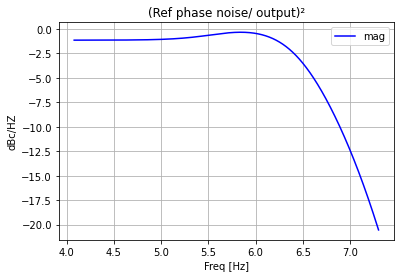

In [1438]:
#Transfer function of different blocks 
#Transfer function of CP phase output to phase of Reference
T_out_ref=Bs
(mag_out_ref, phase_out_ref, w) = control.bode_plot(T_out_ref, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_ref)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(Ref phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

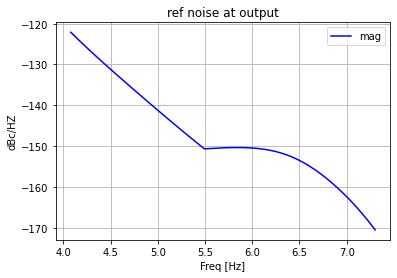

In [1439]:
ref_noise_output=mag_ref*((mag_out_ref)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(ref_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('ref noise at output')
plt.grid() 
plt.legend(labels=('mag',))

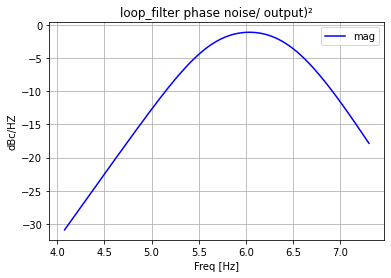

In [1440]:
#Transfer function of different blocks 
#Transfer function of LOOP_FILTER phase output to phase of Reference

s_=control.tf([1,0],[1])
T_out_loop_filter=((KVCO/s_)*(1/P_divider))/(1+Ts)
(mag_out_loop_filter, phase_out_loop_filter, w) = control.bode_plot(T_out_loop_filter, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_loop_filter)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('loop_filter phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

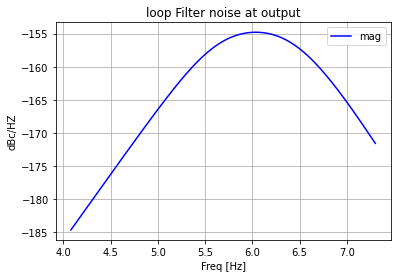

In [1441]:
loop_filter_noise_output=(4.112e-21)*4*R1*((mag_out_loop_filter)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(loop_filter_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('loop Filter noise at output')
plt.grid() 
plt.legend(labels=('mag',))

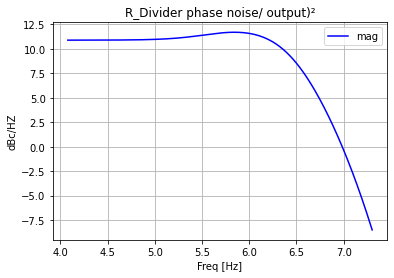

In [1442]:
#Transfer function of R_Divider phase output to phase of Reference

T_out_R_Divider=Bs*R_ratio
(mag_out_R_Divider, phase_out_R_Divider, w) = control.bode_plot(T_out_R_Divider, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_R_Divider)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('R_Divider phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

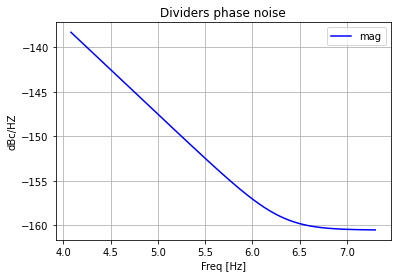

In [1443]:
# Divider transfer phase noise 
T_Divider=control.tf([1,2*2e6*pi],[1,0])
T_Divider=T_Divider*(7.0710678e-17)*1.25

(mag_Divider, phase_rad_Divider, w) = control.bode(T_Divider, w,dB=True,Hz=True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('Dividers phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [1444]:
T_Divider 

TransferFunction(array([8.83883475e-17, 1.11072073e-09]), array([1, 0]))

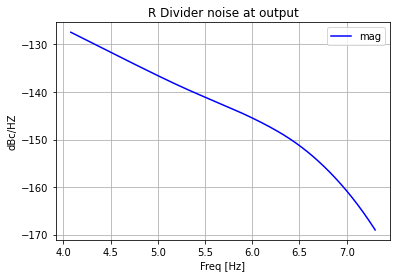

In [1445]:
R_divider_noise_output=((mag_out_R_Divider)**2)*mag_Divider
plt.plot(np.log10(w/(2*pi)), 10*np.log10(R_divider_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('R Divider noise at output')
plt.grid() 
plt.legend(labels=('mag',))

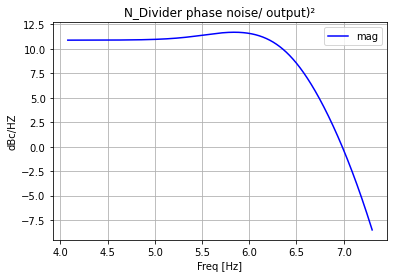

In [1446]:
#Transfer function of N_Divider phase output to phase of Reference

T_out_N_Divider=Bs*R_ratio
(mag_out_N_Divider, phase_out_N_Divider, w) = control.bode_plot(T_out_N_Divider, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_N_Divider)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('N_Divider phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

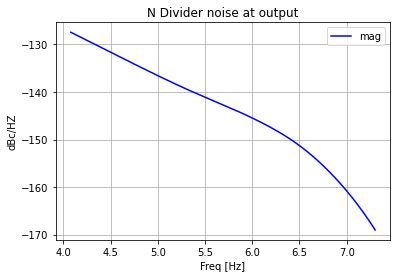

In [1447]:
N_divider_noise_output=((mag_out_N_Divider)**2)*mag_Divider
plt.plot(np.log10(w/(2*pi)), 10*np.log10(N_divider_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('N Divider noise at output')
plt.grid() 
plt.legend(labels=('mag',))

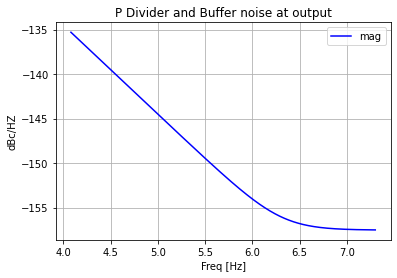

In [1448]:

plt.plot(np.log10(w/(2*pi)), 10*np.log10(2*mag_Divider), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('P Divider and Buffer noise at output')
plt.grid() 
plt.legend(labels=('mag',))

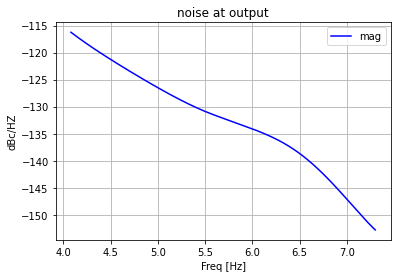

In [1449]:
#calculation every noise at the output 
noise_output=VCO_noise_output+CP_noise_output+ref_noise_output+loop_filter_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('mag',))

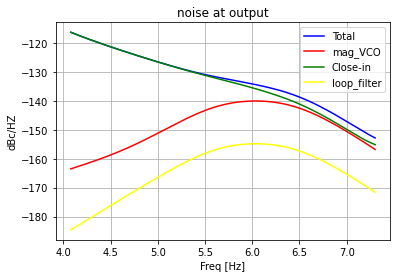

In [1454]:
#comparison
noise_output=VCO_noise_output+CP_noise_output+ref_noise_output+loop_filter_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
noise_output_comp=CP_noise_output+ref_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output), 'blue') 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output), 'red')
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output_comp), 'green') 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(loop_filter_noise_output), 'yellow') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('Total','mag_VCO','Close-in','loop_filter',))

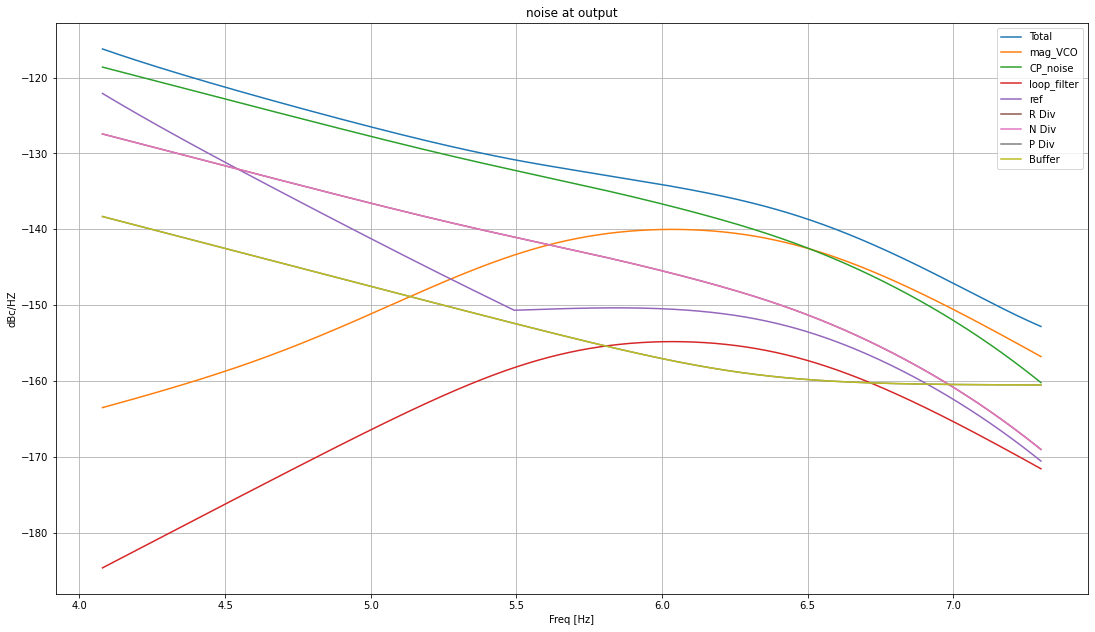

In [1451]:
#comparison
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
noise_output=VCO_noise_output+CP_noise_output+ref_noise_output+loop_filter_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
noise_output_comp=CP_noise_output+ref_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output))
# plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output_comp)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(CP_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(loop_filter_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(ref_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(R_divider_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(N_divider_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider)) 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('Total','mag_VCO','CP_noise','loop_filter','ref','R Div','N Div','P Div','Buffer'))

In [1452]:
def jitter(y):
    w=np.linspace(2*pi*12e3,2*pi*20e6,100000)
    jitter= np.trapz(y, x=w/(2*pi))
    jitter=jitter*2
    jitter=(math.sqrt(jitter))/(2*pi*560e6)
    return(jitter*1e15)

In [1453]:
jitter(noise_output)

184.58549027582114

In [1455]:
# to calculate contribution of eact block 
def jitter(y):
    w=np.linspace(2*pi*12e3,2*pi*20e6,100000)
    jitter= np.trapz(y, x=w/(2*pi))
    jitter=jitter*2
#     jitter=(math.sqrt(jitter))/(2*pi*560e6)
    return(jitter*1e15)

In [1456]:
(jitter(VCO_noise_output)/jitter(noise_output))*100

20.858974824729128

In [1457]:
(jitter(CP_noise_output)/jitter(noise_output))*100

56.43617477210153

In [1458]:
(jitter(ref_noise_output)/jitter(noise_output))*100

4.69089992488061

In [1459]:
(jitter(loop_filter_noise_output)/jitter(noise_output))*100

0.6923903707683113

In [1460]:
(jitter(R_divider_noise_output)/jitter(noise_output))*100

7.423731133894046

In [1461]:
(jitter(N_divider_noise_output)/jitter(noise_output))*100

7.423731133894046

In [1462]:
(jitter(2*mag_Divider)/jitter(noise_output))*100

2.4740978397323077